In [25]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.
!cd ~/aiffel/lxmert

from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

print(torch.__version__)

1.8.1+cu102


In [26]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL)
print(len(objids))
print(objids[:30])  #1600개의 단어사전 중 30개만 출력

1600
['yolk', 'goal', 'bathroom', 'macaroni', 'umpire', 'toothpick', 'alarm clock', 'ceiling fan', 'photos', 'parrot', 'tail fin', 'birthday cake', 'calculator', 'catcher', 'toilet', 'batter', 'stop sign,stopsign', 'cone', 'microwave,microwave oven', 'skateboard ramp', 'tea', 'dugout', 'products', 'halter', 'kettle', 'kitchen', 'refrigerator,fridge', 'ostrich', 'bathtub', 'blinds']


In [27]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])   #400개의 단어사전 중 30개만 출력

400
['gray,grey', 'multi colored,multi-colored,multicolored', 'double decker,double-decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate']


In [28]:
# VQA answer definition
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)
print(len(vqa_answers))
print(vqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

3129
['', 'woods', 'trash can', 'hanging', 'wooden', 'cooking', 'china', 'kids', 'bike rack', 'on phone', 'music', 'travel', 'tulip', 'arrow', 'branch', 'chevron', 'mouth', 'on right', 'rice', 'plate', 'lots', 'nature', 'fruits', 'throwing frisbee', 'blonde', 'life jacket', 'ham', 'hay', 'hat', 'to get to other side']


In [29]:
# 위 이미지의 URL
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [30]:
print(images)
print(sizes)

tensor([[[[  61.0199,   61.2689,   62.1015,  ...,   50.5607,   50.1444,
             50.0199],
          [  60.8955,   61.1445,   61.9771,  ...,   50.8094,   50.3931,
             50.2686],
          [  60.4793,   60.7282,   61.5609,  ...,   51.6420,   51.2256,
             51.1012],
          ...,
          [ -87.9801,  -88.0373,  -88.2285,  ...,   21.7716,   21.5466,
             21.4793],
          [ -87.9801,  -88.0891,  -88.4536,  ...,   21.9628,   21.9110,
             21.8955],
          [ -87.9801,  -88.1046,  -88.5209,  ...,   22.0199,   22.0199,
             22.0199]],

         [[  48.0535,   48.4269,   49.6759,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.9291,   48.2871,   49.4843,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.5129,   47.8190,   48.8429,  ...,   41.5943,   41.1780,
             41.0535],
          ...,
          [ -99.9465,  -99.9364,  -99.9026,  ...,   13.8052,   13.5802,
             13.5129],
          [ -99.94

In [32]:
test_questions_for_url1 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",]

## F-RCNN

In [33]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj53/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [34]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

In [35]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [36]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[1.0372e+02, 1.3613e+02, 2.2735e+02, 1.6974e+02],
         [8.4005e+01, 1.1941e+02, 2.4814e+02, 1.7585e+02],
         [0.0000e+00, 8.1354e+01, 3.2642e+02, 2.6568e+02],
         [3.8475e+02, 3.7221e+01, 4.9974e+02, 3.3300e+02],
         [2.9875e+01, 0.0000e+00, 4.3054e+02, 1.3465e+02],
         [1.5929e+02, 9.1682e+01, 3.7275e+02, 2.4955e+02],
         [6.7672e-01, 2.4750e+02, 2.7701e+02, 3.3300e+02],
         [1.6578e+02, 1.2526e+02, 3.4723e+02, 2.1946e+02],
         [0.0000e+00, 7.1275e+01, 2.1836e+02, 3.0790e+02],
         [5.2669e+01, 1.7062e+00, 2.6646e+02, 1.8314e+02],
         [6.1805e+01, 2.4761e+02, 4.2838e+02, 3.3299e+02],
         [1.2076e+01, 1.1892e+02, 3.6657e+02, 3.0462e+02],
         [1.9641e+02, 1.0624e+02, 3.5971e+02, 1.9710e+02],
         [9.1356e+01, 1.1064e+02, 4.1889e+02, 2.8040e+02],
         [1.2139e+02, 1.0626e+01, 4.8306e+02, 1.6577e+02],
         [3.0271e+02, 1.0307e+02, 3.2805e+02, 1.2879e+02],
         [2.9658e+02, 5.5949e+00, 4.9991e+02, 2.7482e+02

In [37]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[2.4822e-03, 2.3580e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.3088e+00],
         [2.6639e-01, 1.0124e+00, 0.0000e+00,  ..., 9.0339e-04,
          1.5285e-02, 3.0090e+00],
         [6.0975e-01, 0.0000e+00, 0.0000e+00,  ..., 1.0956e-01,
          2.5223e-01, 1.7357e+00],
         ...,
         [7.9118e-01, 2.3213e-01, 0.0000e+00,  ..., 2.2883e-02,
          7.2807e-03, 6.4609e-01],
         [0.0000e+00, 1.4173e+00, 0.0000e+00,  ..., 0.0000e+00,
          2.0937e+00, 1.9630e+00],
         [1.0801e+00, 8.3446e-01, 0.0000e+00,  ..., 1.2504e-02,
          3.0912e-01, 6.6703e-01]]])
-------------
torch.Size([1, 36, 2048])


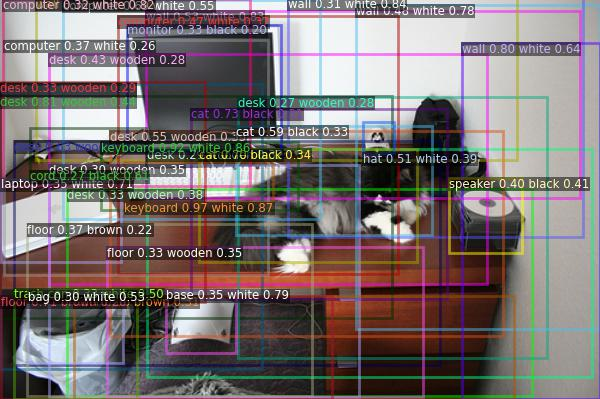

In [38]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [39]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

## 모델구성:LxmertTokenizer

In [40]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [49]:
test_question = ["What is near the disk?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [50]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2054, 2003, 2379, 1996, 9785, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


## 모델구성: LxmertModel

In [51]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [52]:
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_vqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[-4.8011, -2.3278,  6.5088,  ..., -1.3233,  1.5725,  0.5884]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [53]:
len(output_vqa["question_answering_score"][0])

3129

In [54]:
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa

tensor([1770])

In [56]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['What is near the disk?']
prediction from LXMERT VQA: cat


## VQA Inference

In [58]:
test_questions_for_url1 = [
    "Where is this scene?",
    "what is near the disk?",
    "What is the color of the cat?",
    "What is the shape of the monitor?"
]

for test_question in test_questions_for_url1:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is this scene?']
prediction from LXMERT VQA: office
Question: ['what is near the disk?']
prediction from LXMERT VQA: cat
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: black and white
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: rectangle


# Step 2: GQA Data Version

In [59]:

GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"

lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

Downloading: 100%|██████████| 880/880 [00:00<00:00, 434kB/s]
Downloading: 100%|██████████| 848M/848M [01:14<00:00, 11.4MB/s]


In [60]:

# GQA answer definition
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
gqa_answers = utils.get_data(GQA_URL)
print(len(gqa_answers))
print(gqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

1842
['cat food', 'elephant', 'gloves', 'football', 'dock', 'shops', 'water', 'light blue', 'chair', 'players', 'tourist', 'magnet', 'railroad', 'ski lift', 'mirror', 'leggings', 'hurdle', 'shuttle', 'wildflowers', 'flowers', 'cooking pot', 'pipe', 'swan', 'girl', 'celery', 'brown', 'ambulance', 'steps', 'power line', 'asphalt']


In [61]:

# 위 이미지의 URL
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [62]:
print(images)
print(sizes)

tensor([[[[  61.0199,   61.2689,   62.1015,  ...,   50.5607,   50.1444,
             50.0199],
          [  60.8955,   61.1445,   61.9771,  ...,   50.8094,   50.3931,
             50.2686],
          [  60.4793,   60.7282,   61.5609,  ...,   51.6420,   51.2256,
             51.1012],
          ...,
          [ -87.9801,  -88.0373,  -88.2285,  ...,   21.7716,   21.5466,
             21.4793],
          [ -87.9801,  -88.0891,  -88.4536,  ...,   21.9628,   21.9110,
             21.8955],
          [ -87.9801,  -88.1046,  -88.5209,  ...,   22.0199,   22.0199,
             22.0199]],

         [[  48.0535,   48.4269,   49.6759,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.9291,   48.2871,   49.4843,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.5129,   47.8190,   48.8429,  ...,   41.5943,   41.1780,
             41.0535],
          ...,
          [ -99.9465,  -99.9364,  -99.9026,  ...,   13.8052,   13.5802,
             13.5129],
          [ -99.94

In [63]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

In [64]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj53/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [65]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

In [66]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [67]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[1.0372e+02, 1.3613e+02, 2.2735e+02, 1.6974e+02],
         [8.4005e+01, 1.1941e+02, 2.4814e+02, 1.7585e+02],
         [0.0000e+00, 8.1354e+01, 3.2642e+02, 2.6568e+02],
         [3.8475e+02, 3.7221e+01, 4.9974e+02, 3.3300e+02],
         [2.9875e+01, 0.0000e+00, 4.3054e+02, 1.3465e+02],
         [1.5929e+02, 9.1682e+01, 3.7275e+02, 2.4955e+02],
         [6.7672e-01, 2.4750e+02, 2.7701e+02, 3.3300e+02],
         [1.6578e+02, 1.2526e+02, 3.4723e+02, 2.1946e+02],
         [0.0000e+00, 7.1275e+01, 2.1836e+02, 3.0790e+02],
         [5.2669e+01, 1.7062e+00, 2.6646e+02, 1.8314e+02],
         [6.1805e+01, 2.4761e+02, 4.2838e+02, 3.3299e+02],
         [1.2076e+01, 1.1892e+02, 3.6657e+02, 3.0462e+02],
         [1.9641e+02, 1.0624e+02, 3.5971e+02, 1.9710e+02],
         [9.1356e+01, 1.1064e+02, 4.1889e+02, 2.8040e+02],
         [1.2139e+02, 1.0626e+01, 4.8306e+02, 1.6577e+02],
         [3.0271e+02, 1.0307e+02, 3.2805e+02, 1.2879e+02],
         [2.9658e+02, 5.5949e+00, 4.9991e+02, 2.7482e+02

In [68]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[2.4822e-03, 2.3580e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.3088e+00],
         [2.6639e-01, 1.0124e+00, 0.0000e+00,  ..., 9.0339e-04,
          1.5285e-02, 3.0090e+00],
         [6.0975e-01, 0.0000e+00, 0.0000e+00,  ..., 1.0956e-01,
          2.5223e-01, 1.7357e+00],
         ...,
         [7.9118e-01, 2.3213e-01, 0.0000e+00,  ..., 2.2883e-02,
          7.2807e-03, 6.4609e-01],
         [0.0000e+00, 1.4173e+00, 0.0000e+00,  ..., 0.0000e+00,
          2.0937e+00, 1.9630e+00],
         [1.0801e+00, 8.3446e-01, 0.0000e+00,  ..., 1.2504e-02,
          3.0912e-01, 6.6703e-01]]])
-------------
torch.Size([1, 36, 2048])


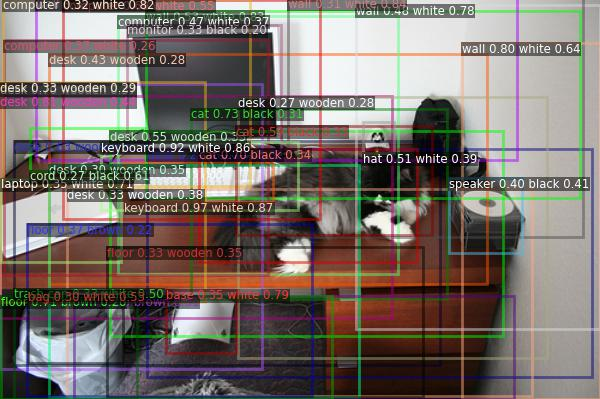

In [69]:

# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [70]:

#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [71]:
test_question = ["What is near the disk?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [72]:

print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2054, 2003, 2379, 1996, 9785, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [73]:
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [74]:
output_gqa = lxmert_gqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_gqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[ 1.6444, -2.7622,  0.1815,  ..., -0.5570, -0.1211,  2.0017]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [75]:
len(output_gqa["question_answering_score"][0])

1842

In [76]:

# get prediction
pred_gqa = output_gqa["question_answering_score"].argmax(-1)

pred_gqa

tensor([621])

In [77]:
print("Question:", test_question)
print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])

Question: ['What is near the disk?']
prediction from LXMERT GQA: can


In [78]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", gqa_answers[pred_gqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: desk
Question: ['What is near the disk?']
prediction from LXMERT VQA: can
Question: ['What is the color of the table?']
prediction from LXMERT VQA: brown
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: black
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: square
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white


## 근접한 답안을 내지만 step1에 비해 정확도가 떨어지는것같다.